In [1]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

In [2]:
from typing import Annotated, List, TypedDict
from langchain_core.documents import Document
import operator

class GraphState(TypedDict):
    context: Annotated[List[Document], operator.add]        # 문서의 검색 결과
    answer: Annotated[List[Document], operator.add]         # 답변
    question: Annotated[str, 'user question']               # 질문
    sql_query: Annotated[str, 'sql query']                  
    binary_score: Annotated[str, 'binary score yes or no']

In [3]:
def retrieve(state: GraphState) -> GraphState:          # 문서 검색 노드
    # retrieve: 검색
    
    documents = '검색된 문서'
    return {'context': documents}

In [4]:
def rewrite_query(state: GraphState) -> GraphState:
    # Query Transform: 쿼리 다시 작성

    documents = '검색된 문서'
    return GraphState(context=documents)

In [5]:
def llm_gpt_execute(state: GraphState) -> GraphState:
    # LLM 실행

    answer = 'GPT에서 생성된 답변'
    return GraphState(answer=answer)

In [7]:
def relevance_check(state: GraphState) -> GraphState:   # 관련성 체크 노드
    # Relevance Check: 관련성 확인

    binary_score = 'yes'
    return GraphState(binary_score=binary_score)

In [8]:
def sum_up(state: GraphState) -> GraphState:
    # sum_up: 결과 종합

    answer = '종합된 답변'
    return GraphState(answer=answer)

In [9]:
def decision(state: GraphState) -> GraphState:
    # 의사 결정
    decision = '결정'
    

    if state['binary_score'] == 'yes':
        return 'PASS'
    elif state['binary_score'] == 'no':
        return 'QUERY ERROR'
    else:
        return 'UNKNOWN MEANING' 

In [11]:
def get_table_info(state: GraphState) -> GraphState:
    # Get Table Info: 테이블 정보 가져오기
    table_info = '테이블 정보'
    return GraphState(context=table_info)

In [12]:
def generate_sql_query(state: GraphState) -> GraphState:
    # Make SQL Query: SQL 쿼리 생성
    sql_query = 'SQL 쿼리'
    return GraphState(sql_query=sql_query)

In [13]:
def execute_sql_query(state: GraphState) -> GraphState:
    # Execute SQL Query: SQL 쿼리 실행
    sql_result = 'SQL 결과'
    return GraphState(context=sql_result)

In [14]:
def validate_sql_query(state: GraphState) -> GraphState:
    # Validate SQL Query: SQL 쿼리 검증
    binary_score = 'SQL 쿼리 검증 결과'
    return GraphState(binary_score=binary_score)

In [10]:
from langgraph.checkpoint.memory import MemorySaver
from langchain_teddynote.graphs import visualize_graph
from langgraph.graph import StateGraph, END

In [15]:
######### 1. 그래프 생성 #########

workflow = StateGraph(GraphState)

In [16]:
######### 2. 노드 정의  #########

# 노드 이름, 함수 이름을 넣으서 노트를 추가
workflow.add_node('질문', retrieve)

workflow.add_node('rewrite_query', rewrite_query)
workflow.add_node('rewrite_question', rewrite_query)

workflow.add_node('GPT 요청', llm_gpt_execute)
workflow.add_node('GPT_relevance_check', relevance_check)

workflow.add_node('결과 종합', sum_up)

workflow.add_node('get_table_info', get_table_info)
workflow.add_node('generate_sql_query', generate_sql_query)
workflow.add_node('execute_sql_query', execute_sql_query)
workflow.add_node('validate_sql_query', validate_sql_query)

In [17]:
######### 3. 그래프 엣지(Edge) 추가  #########

workflow.add_edge('질문', 'get_table_info')
workflow.add_edge('get_table_info', 'generate_sql_query')
workflow.add_edge('generate_sql_query', 'execute_sql_query')
workflow.add_edge('execute_sql_query', 'validate_sql_query')

In [18]:
workflow.add_conditional_edges(
    'validate_sql_query', 
    decision, 
    {
        'QUERY ERROR': 'rewrite_query',
        'UNKNOWN MEANING': 'rewrite_question',
        'PASS': 'GPT 요청'
        
    }
)

In [19]:
workflow.add_edge('rewrite_query', 'execute_sql_query')
workflow.add_edge('rewrite_question', 'rewrite_query')
workflow.add_edge('GPT 요청', 'GPT_relevance_check')
workflow.add_edge('GPT_relevance_check', '결과 종합')
workflow.add_edge('결과 종합', END)

In [20]:
######### 4. 그래프 진입점  #########

workflow.set_entry_point('질문')

In [21]:
######### 5. 체크 포인터 설정  #########

memory = MemorySaver()

In [22]:
######### 6. 그래프 컴파일(compile)  #########

app = workflow.compile(checkpointer=memory)

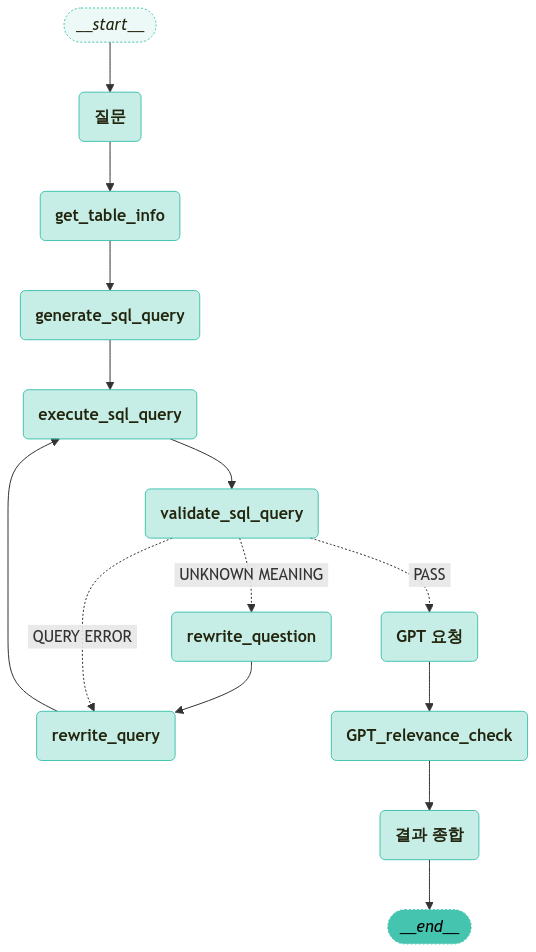

In [23]:
visualize_graph(app)